# Railgun Model

Thomas Jagielski and Duncan  Mazza

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import math
import matplotlib

## Introduction

Railguns are powerful tools that can be used to launch projectiles at extremely high velocity using electromagnetic forces. While connotations of railguns are typically in the realm of weaponry and military usage, they could also be used to assist in launching satellites into space, propelling plasma, or launching baseballs at very high velocities.

A typical railgun is composed of the following primary components:
- Two long parallel rails made of magnetic material

- A power supply capable of discharging very quickly, connected by the positive lead to one end of the rails and by the negative lead to the same end of the other rail.

- A conductive armature (the object propelled by the Lorentz force)

- A projectile pushed by the armature (if the armature is not the projectile itself)

A diagram is included later that further details the anatomy of railguns. 

## Questions

1. What is the launch velocity of a projectile (in this case, a baseball) from a railgun with a given current and given specifications of the armature, projectile, rails, etc.?


2. With a target of a given location (in a 2D plane in line with the railgun's rails) and a given launch velocity determined by the railgun model, what angle from the horizontal axis will result in the baseball striking the target? 

### Force Diagram
This cartoon doubles as our free body diagram of the railgun model. The forces acting on the armature are shown as force vectors and represented below mathematically.

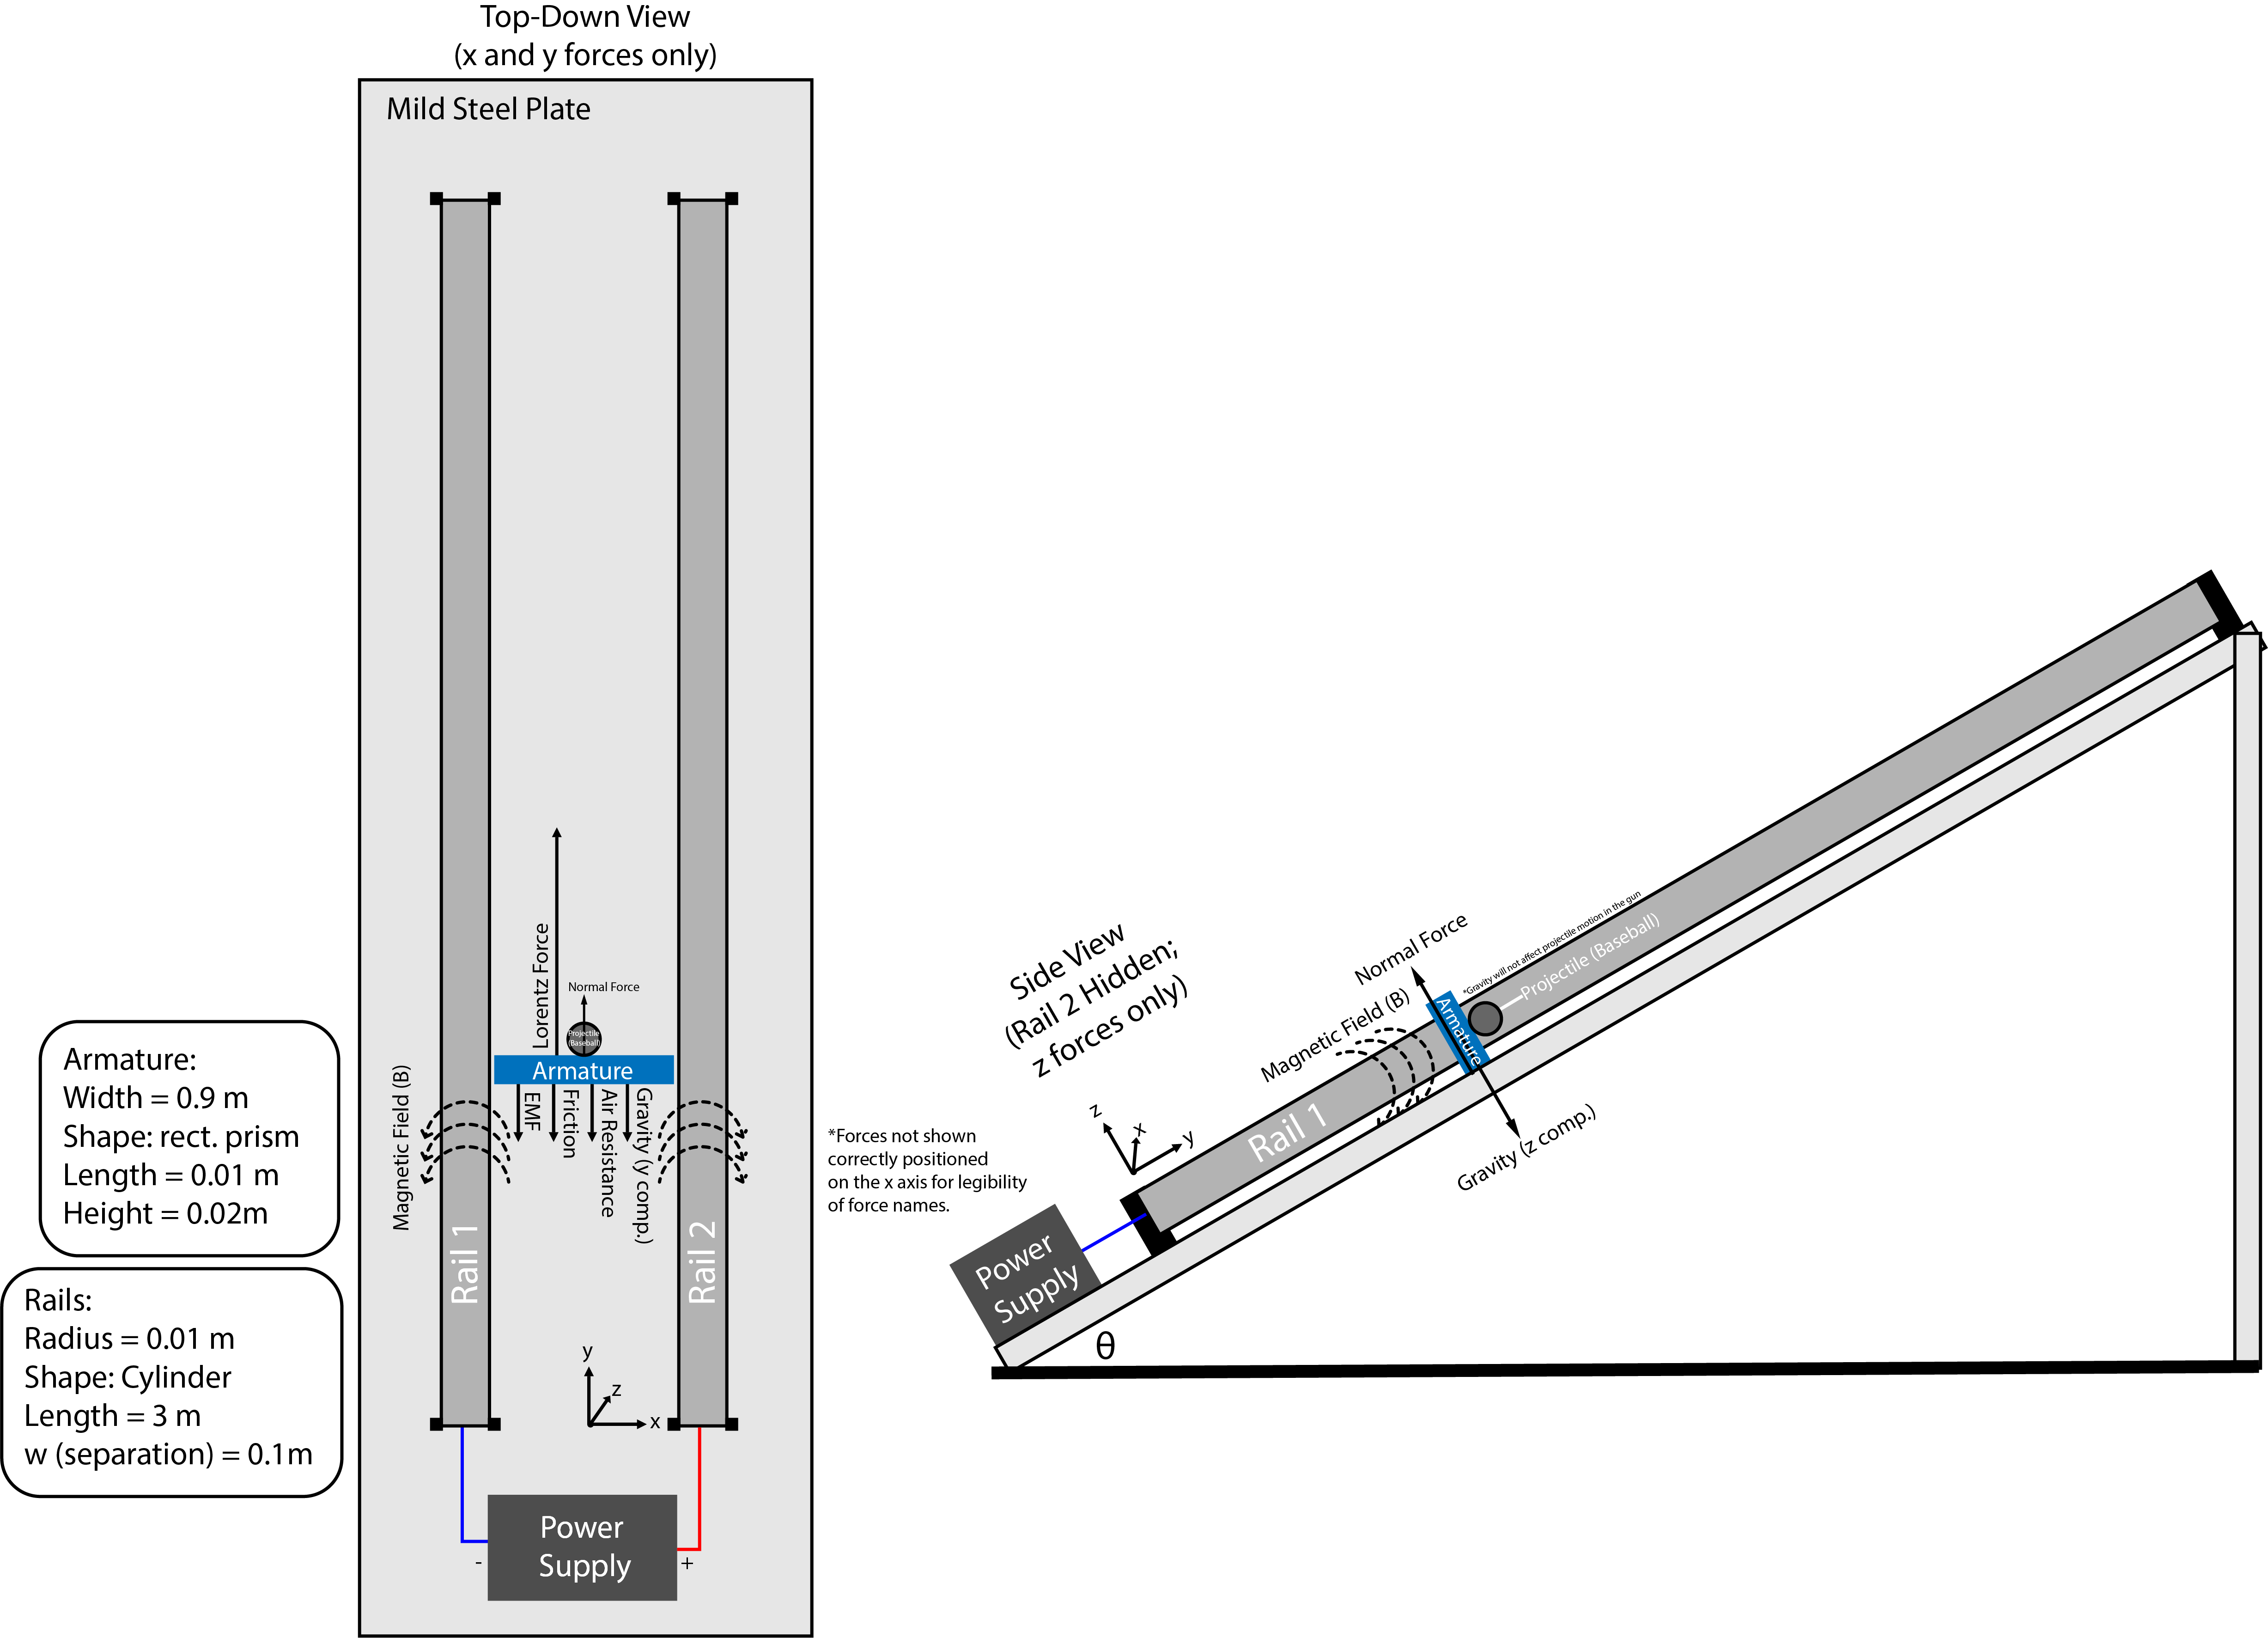

### Equations used for railgun

$$F_{Lorentz} = \frac{\mu_0 I^2}{2 \pi} \ln \frac{R + w}{R}$$

$$F_{EMF} = -B \gamma w \textrm {, where:}$$

$$B = \frac{\mu_0 I}{2 \pi w} \ln \frac{R + w}{R}$$

$$F_{friction} = \mu_d F_{g_y} m_{arm} \textrm {, where:} $$

$$ F_{g_y} = F_g cos(\theta)$$

Variables are labeled in the parameter objects with their units and what they represent, except for `rail_r` which is expressed as $R$ and `current` which is expressed as $I$. Derivation for equations can be found in the paper (linked at the bottom) on railgun physics. 

### Assumptions and Constraints

To use the aforementioned equations, the following assumptions/constraints must be considered: 

- Constant Lorentz force, which is dependent on:    

    - Constant current
    
    - The rails are made of a magnetic material with a magnetic permeability of free space constant: $\mu_0 = 10 \textrm{ } \frac{H}{m}$
    
    - Rails are separated enough (by length w) relative to their diameter
    
    - Rails are long enough relative to their separation (w) so they can be treated by the equations as rails of infinite length.
    
    - Armature is made of copper (conductive)
    
    - Rails are cylindrical and wire-like (small diameter)
    
    - Uniform current density
    
    - Thin armature
    
    - Constant $\mu_0$
    
    - No energy loss to magnetization
    
    - No energy lost to eddy currents
    
- Coefficient of drag for armature is constant and is 2

- Flow speed around armature equals the armatures velocity

These assumptions and constraints are incorporated into our model parameters:

In [2]:
num_sweeps = 15
angle_elevation = Params(angle_elevation = pi / 4);

params = Params(mass_proj = 0.145, #kg
                rail_r = 0.01, #m rail radius
                rail_l = 3, #m rail length
                arm_w = 0.9, #m armature width in x axis
                arm_l = 0.01, #m armature length in y axis
                arm_d = 0.02, #m armature depth in z axis
                w = 0.1, #m rail separation
                mu = 10, #H/m permeability constant of rails 
                rho_cu = 8960, #g/m^3 density of Cu (copper)
                v_init = 0, #m/s
                y_init = 0, #m
                t_end = 1000,
                coef_fric = 0.36, #dimensionless, dynamic friction 
                                  #between copper and mild steel 
                                  #(the surface that the copper armature 
                                  #slides against)
                g = 9.8, #m/s*s
                angle_elevation = angle_elevation.angle_elevation, #radians 
                                                                   #from 
                                                                   #horizontal; 
                                                                   #being swept
                cd = 2, # approximate drag coefficient of a rectangular box 
                rho_air = 1.225, # kg/m^3 density of air
                current = 1000 # amperes
                )
;

''

In [3]:
def make_system(params):
    """Make a system object.
    
    params: parameter object
    
    returns: System object
    """

    unpack(params)
    
    mass_arm = (arm_w * arm_l * arm_d) * rho_cu
    
    # Magnetic force in railgun on armature
    lorentz_force = (((mu * current**2)/(2 * np.pi))
                    * (math.log((rail_r + w) / rail_r)))
    
    # Magnetic field strength
    B = ((mu * current)/(2 * np.pi * w)) * (math.log((rail_r + w) / rail_r))
    
    # Friction force on armature
    arm_friction = coef_fric * (g * mass_arm * math.cos(angle_elevation))
    
    # Force of gravity in y direction
    gravity_y_direc = g * mass_arm * math.sin(angle_elevation)
    
    # Cross-sectional area of armature
    front_area = arm_w * arm_d #m^2 frontal areaa of the armature 
    
    init = State(v=v_init, y=y_init)
    
    return System(params, lorentz_force=lorentz_force, mass_arm = mass_arm,
                  B = B, arm_friction = arm_friction, 
                  gravity_y_direc = gravity_y_direc, 
                  front_area = front_area, init=init)

In [4]:
system = make_system(params);

### Modeling Decisions



In [5]:
def slope_func(state, t, system):
    """Define differential equations for velocity and acceleration
    
    state: v = velocity, y = position in railgun
    t: time
    system: System object
    
    returns: acceleration and velocity
    """
    
    unpack(system)
    v, y = state
    
    # Electromagnetic force
    emf = B * v * w 
    
    # The u of the drag force equation will be set equal to velocity (v)
    air_resistance = 0.5 * rho_air * (v**2) * cd * front_area
    
    # Acceleration of the armature and projectile
    dvdt = ((lorentz_force - emf - arm_friction - gravity_y_direc - air_resistance) 
           / (mass_proj + mass_arm))
    
    # Velocity of armature and projectile
    dydt = v    

    return dvdt, dydt

In [6]:
slope_func(system.init, 0, system)

(2171096.6306084436, 0.0)

In [7]:
def event_func(state, t, system):
    """Event function to stop the simulation when the 
       armature reaches the end of the rails
    
    state: v = velocity, y = position in railgun
    t: time
    system: System object
    
    returns: the difference between armature position and length of rails
    """
    
    v, y = state
    return system.rail_l - y

In [8]:
results, details = run_ode_solver(system, slope_func, events = event_func, 
                                  max_step=0.00001)
details.message

'A termination event occurred.'

### Results

In [9]:
print('The final velocity of the armature (or the exit velocity of ' 
      'the projectile) is {} m/s'.format(get_last_value(round(results.v, 3))))

The final velocity of the armature (or the exit velocity of the projectile) is 993.798 m/s


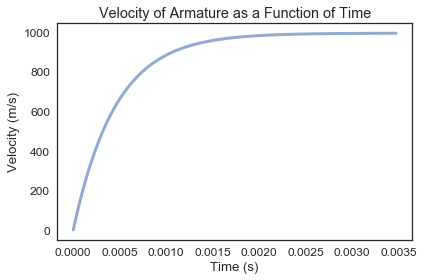

In [10]:
plot(results.v)

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)',
         title='Velocity of Armature as a Function of Time',
         legend=False)

### Interpretation

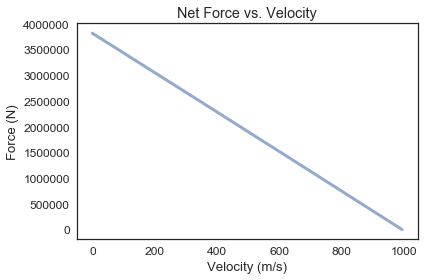

In [11]:
net_force = []
v_list = []

for i in results.index:
    v_list.append(results.v[i])
    net_force.append(-(system.B * results.v[i] * system.w) 
                     - (0.5 * system.rho_air * (results.v[i]**2) 
                        * system.cd * system.front_area)
                     - system.arm_friction
                     - system.gravity_y_direc
                     + system.lorentz_force) 
plot(v_list, net_force, label = 'Net Force')

decorate(xlabel = 'Velocity (m/s)',
         ylabel = 'Force (N)',
         legend = False,
         Title = 'Net Force vs. Velocity')

The velocity of the armature and projectile as a function of time reach is asymptotic, which is explained through the balancing of forces.  The plot above shows the net force as a function of velocity. As the velocity increases, the net force decreases proportionally until the net force, and therefore acceleration, become zero. 

### Limitations

This model functions for the basic physics of railguns; however, many assumptions had to be made.  Due to this, one of the shortcomings of our model is that railguns are not built this way in practice.  For example, our model assumes cylindrical and wire-like rails; whereas, railguns (in practice) have non-cylindrical rails that are more effective but harder to model mathematically.  Thus, only for the railgun we modeled, the results are accurate.

## Projectile Motion 

The projectile in the railgun is a baseball and will be modeled with a given initial launch angle, height, and velocity. The baseball's drag will be velocity dependent, as the coefficient of drag ($c_d$) will vary according to interpolated data from `baseball_drag.csv`. 

##### Projectile Question Restated

With a target of a given location (in a 2D plane in line with the railgun's rails) and a given launch velocity determined by the railgun model, what angle from the horizontal axis will result in the baseball striking the target? 

The parameters for our target are the target's x and y position in a 2D plane. The coordinate system between the railgun and the projectile are reset, where x represents horizontal distance between the railgun and the target, and y is the vertical height from the ground.

### Assumptions

- The projectile is a baseball and follows the drag coefficient curve given by `data/baseball_drag.csv`
- No wind in any direction
- No angular velocity of the baseball

In [12]:
params_proj = Params(x = 0, #m 
                     g = 9.8, #m/s^2
                     mass = 145e-3, #kg mass of projectile
                     diameter = 73e-3, #m diameter of projectile
                     rho = 1.2, #kg/m^3 density of air
                     C_d = 0.33, #cooefficient of drag
                     angle = params.angle_elevation, #radians
                     velocity = get_last_value(results.v), #m / s
                     t_end = 200, #s
                     target_x = 320, #m
                     target_y = 0, #m
                     target_radius = 0.5 #m
                     )
;

''

In [13]:
def make_system_proj(params, params1):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
    params1: Params object from railgun simulation
               
    returns: System object
    """
    unpack(params)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(params.angle, velocity)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # define y
    y = math.sin(params.angle) * system.rail_l #m
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    return System(params, init=init, area=area, y=y)

In [14]:
system_proj = make_system_proj(params_proj, params);

As the velocity of the baseball increases, the coefficient of drag ($c_d$) varies. This relationship is defined by `baseball_drag.csv` and is interpolated.

In [15]:
m = UNITS.meter
s = UNITS.second

baseball_drag = pd.read_csv('data/baseball_drag.csv')
baseball_drag.index = Quantity(baseball_drag['Velocity in mph'].values, 
                               UNITS.mph).to(m/s)
baseball_drag;

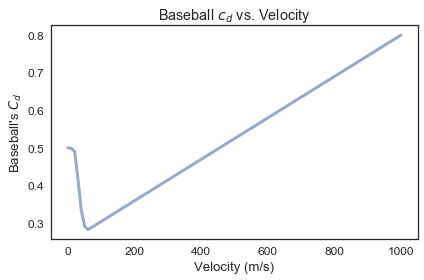

In [16]:
drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 1000, 101)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel = 'Velocity (m/s)', 
         ylabel = "Baseball's $C_d$", 
         title = 'Baseball $c_d$ vs. Velocity', 
         legend = False)

In [17]:
def drag_force(v, system):
    """finds drag force in the opposing direction to velocity
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    
    unpack(system)
    C_d = drag_interp(v.mag)
    mag = -rho * v.mag ** 2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [18]:
def slope_func_proj(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [19]:
slope_func_proj(system_proj.init, 0, system_proj)

(702.721098455984,
 702.721098455984,
 <Quantity(-9628.802796352897, 'dimensionless')>,
 <Quantity(-9638.602796352896, 'dimensionless')>)

In [20]:
def event_func_proj(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [21]:
event_func_proj(system_proj.init, 0, system_proj)

2.121320343559643

In [22]:
system_proj = System(system_proj, drag_interp = drag_interp)
results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, 
                                            max_step=0.05)
details_proj.message

'A termination event occurred.'

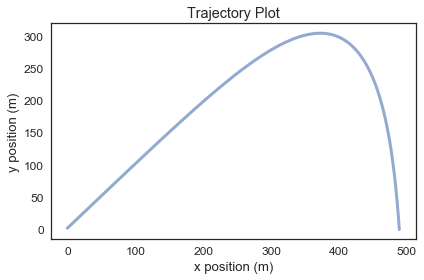

In [23]:
plot(results_proj.x, results_proj.y)

decorate(title='Trajectory Plot', 
         xlabel='x position (m)',
         ylabel='y position (m)',
         legend = False)

In [24]:
def simulation(angle_elevation):
    """Run through all functions in simualtion
    
    angle_elevation: angle between the railgun and ground
    
    returns: Position vector of projectile
    """
    
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, 
                                              events = event_func, 
                                              max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, 
                             velocity = get_last_value(results_sim.v))
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                                events = event_func_proj, 
                                                max_step=0.1)
    
    x = results_proj.x
    y = results_proj.y
    vx = results_proj.vx
    vy = results_proj.vy
    
    xy = Vector(x, y)
    
    return xy, vx, vy

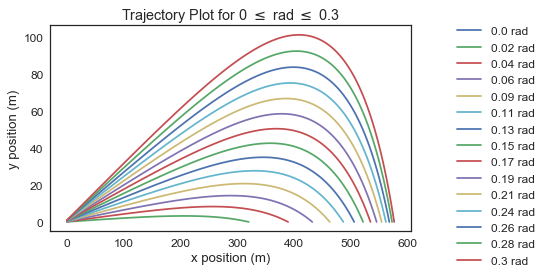

In [25]:
# Sweep angle_elevation
fig = plt.figure()
ax = plt.subplot(111);

for i in range(0, num_sweeps): 
    angle_linspace = linspace(0, 0.3, num_sweeps)
    params.angle_elevation = angle_linspace[i]
    xy, vx, vy = simulation(params.angle_elevation)
    # Plot
    ax.plot(xy.x, xy.y, label = '{} rad'.format(round(angle_linspace[i], 2)))
    decorate(title='Trajectory Plot for 0 $\leq$ rad $\leq$ 0.3', 
             xlabel='x position (m)',
             ylabel='y position (m)',
             )
    ax.legend(bbox_to_anchor=(1.1, 1.05))

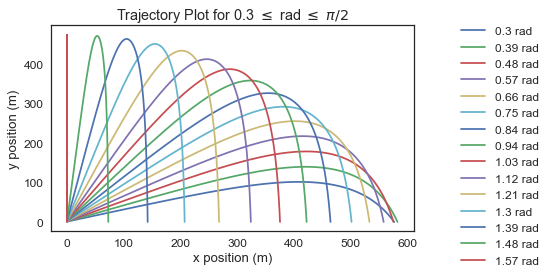

In [26]:
# Sweep angle_elevation for a second time
fig = plt.figure()
ax = plt.subplot(111);

for i in range(0, num_sweeps): 
    angle_linspace = linspace(0.3, pi/2, num_sweeps)
    params.angle_elevation = angle_linspace[i]
    xy, vx, vy = simulation(params.angle_elevation)
    # Plot
    ax.plot(xy.x, xy.y, label = '{} rad'.format(round(angle_linspace[i], 2)))
    decorate(title='Trajectory Plot for 0.3 $\leq$ rad $\leq$ $\pi/2$', 
             xlabel='x position (m)',
             ylabel='y position (m)',
             )
    ax.legend(bbox_to_anchor=(1.1, 1.05))

As evidenced by these graphs, there will be two solutions for angles that will result in a particular impact point. Thus, we will have to indicate to `fsolve` a prediction that is $\leq$ ~0.3 rad. 

In [27]:
# Assuming that the projectile is on the ground (y = 0):
def simulation_hitting_target(angle_elevation):
    """Run through all functions in simualtion
    
    angle_elevation: angle between the railgun and ground
    
    returns: difference between distance of projectile and target distance
    """
    
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, 
                                              events = event_func, 
                                              max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, 
                             velocity = get_last_value(results_sim.v))
    
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                                events = event_func_proj, 
                                                max_step=0.1)
    
    return get_last_value(results_proj.x) - params_proj.target_x

In [28]:
solution = fsolve(simulation_hitting_target, x0 = 0.02);

### Results

In [29]:
print('The angle from horizontal that will cause the projectile to hit the '
      'target is {} radians.'.format(round(solution[0], 5)))

The angle from horizontal that will cause the projectile to hit the target is 0.02137 radians.


### Interpretation

The baseball hits the target with a final speed of 94.8 m/s and with a kinetic energy of 
651.6 joules.


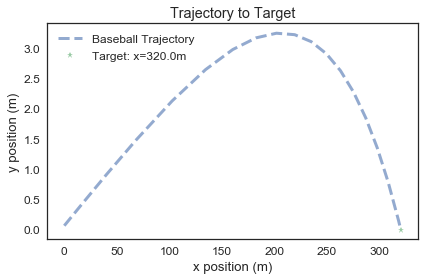

In [30]:
target_sim_xy, target_sim_vx, target_sim_vy = simulation(solution[0])
plot(target_sim_xy.x, target_sim_xy.y, '--', 
     label = 'Baseball Trajectory')
plot(params_proj.target_x, params_proj.target_y, '*',
     label = 'Target: x={}m'.format(params_proj.target_x))
decorate(title='Trajectory to Target',
         xlabel='x position (m)',
         ylabel='y position (m)',
         )
speed = math.sqrt((get_last_value(target_sim_vx))**2 
                  + (get_last_value(target_sim_vy))**2)
kinetic_energy = 0.5 * params_proj.mass * speed **2
print('The baseball hits the target with a final speed of {} m/s and with a '
      "kinetic energy of \n{} joules.".format(round(speed, 2), 
                                            round(kinetic_energy, 2)))

As we swept the launch angle, we used `fsolve` to find the angle at which the projectile must be launched to hit a target.  From this, we found the angle was ~0.02137 radians.  Solving for the final speed and kinetic energy, we found the baseball was traveling at 94.8 meters per second as it hits the target and it has a kinetic energy of 651.6 J.

Because we avoided hard-coding in the parameters, our model will work for any launch velocity and target position on the x axis, provided it is within the maximum range of the railgun. 

### Limitations

Baseballs would most likely explode if they were accelerated at the rate they are in the railgun.  On top of this, the coefficient of drag for a baseball traveling at 1000 m/s is difficult to find.  These limitations inhibit the practicality of the model.  In consideration of these limitations, the targeting aspect of our model is functional because it gives an exact angle of elevation for the railgun.

### Sources

- Source for coeff fric: http://www.engineershandbook.com/Tables/frictioncoefficients.htm

- Source for drag coeff: https://www.engineeringtoolbox.com/drag-coefficient-d_627.html

- Source for railgun physics: http://citeseerx.ist.psu.edu/viewdoc/download?rep=rep1&type=pdf&doi=10.1.1.205.7739

- Source for air density: https://www.engineersedge.com/calculators/air-density.htm

* Some code was adapted from: https://github.com/AllenDowney/ModSimPy/blob/master/code/soln/chap22soln.ipynb